# Exercício 2 de Análise de Componentes Independentes em imagens
Pedro Bandeira de Mello Martins

CPE 782 - Análise de Componentes Independentes

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.cluster.vq import whiten
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy.stats import entropy, chi2_contingency, shapiro
from scipy.misc import imread
from sklearn.decomposition import PCA


%matplotlib inline
from evaluation import calculateNegentropy, kde_entropy, KLdivergence, resultsTable, plot_MutualInformation
from ICAfunctions import cichocki_Feedback, cichocki_Feedforward, NPCA_RLS

#Notes:
#SHAPIRO: The algorithm used is described in [R634] but censoring parameters as 
#        described are not implemented. For N > 5000 the W test statistic is 
#        accurate but the p-value may not be.

In [3]:
def rebuildPicture(x_r, x_g, x_b, original_shape):
    rebuilt = np.zeros(original_shape, np.float64)
    
    x_r = x_r-np.min(x_r)
    x_r = x_r/np.amax(x_r)
    
    x_g = x_g-np.min(x_g)
    x_g = x_g/np.amax(x_g)
    
    x_b = x_b-np.min(x_b)
    x_b = x_b/np.amax(x_b)
    
    rebuilt[:, :, 0] = np.reshape(x_r, (original_shape[0], original_shape[1]))
    rebuilt[:, :, 1] = np.reshape(x_g, (original_shape[0], original_shape[1]))
    rebuilt[:, :, 2] = np.reshape(x_b, (original_shape[0], original_shape[1]))
    
    return rebuilt

def image_histogram_equalization(image, number_bins=256):
    # from http://www.janeriksolem.net/2009/06/histogram-equalization-with-python-and.html

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, normed=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape)


def rgb_ICA(ICA_method, mixturesRGB, learningRate, runs = 2):
    #y = np.zeros(mixturesRGB.shape)

    print(mixturesRGB[:, :, 0].shape)
    
    [y_r, Wr] = ICA_method(mixturesRGB[:, :, 0], learningRate, runs = runs)
    #[y_g, Wg] = ICA_method(mixturesRGB[:, :, 1], learningRate, runs = runs)
    #[y_b, Wb] = ICA_method(mixturesRGB[:, :, 2], learningRate, runs = runs)
    
    pca = PCA(whiten=True)
    whitenedMixturesG = pca.fit_transform(mixturesRGB[:,:,1].T).T
    whitenedMixturesB = pca.fit_transform(mixturesRGB[:,:,2].T).T

    
    y_g = np.dot(Wr, whitenedMixturesG)
    y_b = np.dot(Wr, whitenedMixturesB)
    print(y_r.shape)
    
    y = np.dstack((y_r, y_g, y_b))
    
    print(y.shape)
    
    plt.imshow(np.reshape(y[0,:,0], (400, 500)))
    plt.show()
    
    W = [Wr, Wr, Wr]
    #W = Wr
    
    return y, W



def read_rgb_image(folderPath, n_images = 2, n_channels = 3):
    X1 = imread(folderPath + '\\1_saida.jpg', flatten = False)
    X2 = imread(folderPath + '\\2_saida.jpg', flatten = False)
    X3 = imread(folderPath + '\\3_saida.jpg', flatten = False)

    
    mixtures = np.zeros((n_images, X1.shape[0]*X1.shape[1], n_channels), np.float64)

    mixtures[0, :, 0] = X1[:,:,0].flatten()
    mixtures[0, :, 1] = X1[:,:,1].flatten()
    mixtures[0, :, 2] = X1[:,:,2].flatten()
    
    mixtures[1, :, 0] = X2[:,:,0].flatten()
    mixtures[1, :, 1] = X2[:,:,1].flatten()
    mixtures[1, :, 2] = X2[:,:,2].flatten()
    
    mixtures[2, :, 0] = X2[:,:,0].flatten()
    mixtures[2, :, 1] = X2[:,:,1].flatten()
    mixtures[2, :, 2] = X2[:,:,2].flatten()   
    
    original_shape = X1.shape

    return mixtures, original_shape


In [4]:
learning_rate = 1e-6
n_images = 3

In [5]:
folderPath = 'base_imagens_ica\\2_run'
mixtures, original_shape = read_rgb_image(folderPath, n_images)
print(mixtures.shape)
print(original_shape)

(3, 200000, 3)
(400, 500, 3)


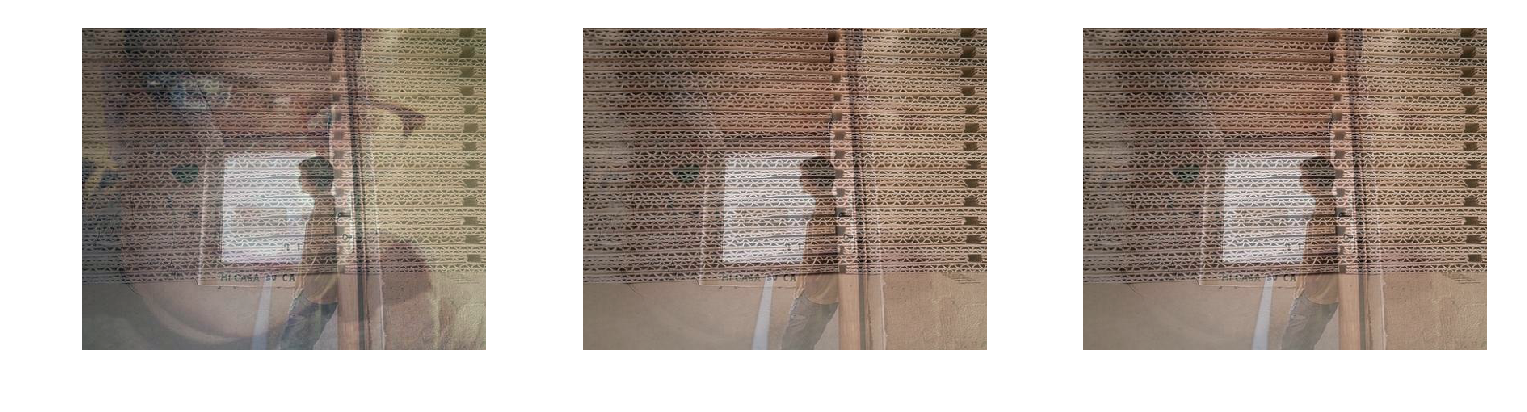

In [6]:
picture1 = rebuildPicture(mixtures[0, :, 0], mixtures[0, :, 1], mixtures[0, :, 2], original_shape)
picture2 = rebuildPicture(mixtures[1, :, 0], mixtures[1, :, 1], mixtures[1, :, 2], original_shape)
picture3 = rebuildPicture(mixtures[2, :, 0], mixtures[2, :, 1], mixtures[2, :, 2], original_shape)

fig, axes = plt.subplots(1,3, dpi = 128+64)
axes[0].imshow(picture1)
axes[1].imshow(picture2)
axes[2].imshow(picture3)

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

fig.tight_layout()

## NPCA-RLS Algorithm

(3, 200000)
Execution time: 28.719675302505493 seconds
(3, 200000)
(3, 200000, 3)


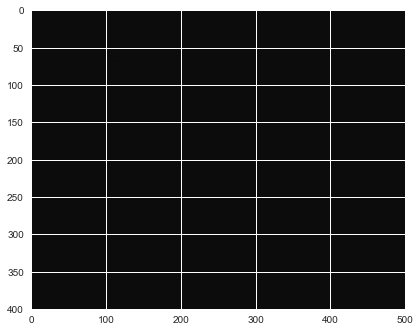

In [43]:
[yNPCA, WNPCA] = rgb_ICA(NPCA_RLS, mixtures, 0.99815)#, (1/1+1e-14))

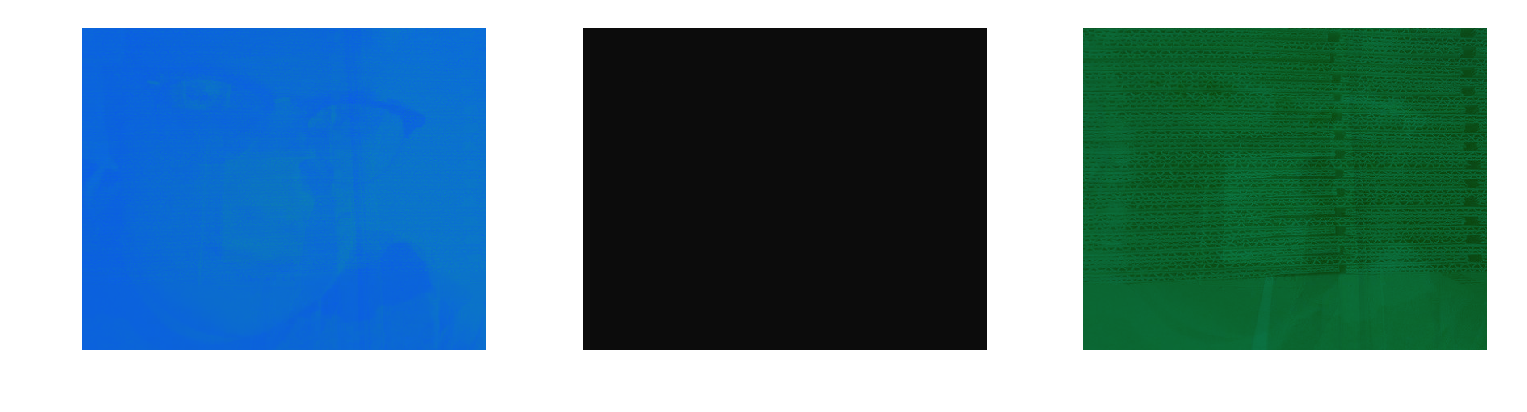

In [54]:
fig, axes = plt.subplots(1,3, dpi = 128+64)
#fig.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=None, wspace=0.001, hspace=0.001)

womanNPCA = rebuildPicture(-yNPCA[0, :, 0], yNPCA[0, :, 1], -yNPCA[0, :, 2], original_shape)
guyNPCA = rebuildPicture(-yNPCA[1, :, 0], yNPCA[1, :, 1], -yNPCA[1, :, 2], original_shape)
fernsterNPCA = rebuildPicture(yNPCA[2, :, 0], -yNPCA[2, :, 1], -yNPCA[2, :, 2], original_shape)

axes[0].imshow(womanNPCA)
axes[1].imshow(guyNPCA)
axes[2].imshow(fernsterNPCA)

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

fig.tight_layout()

## Cichocki-Unbehauen Algorithm Feedback Network

(3, 200000)
Execution time: 39.241068840026855 seconds
(3, 200000)
(3, 200000, 3)


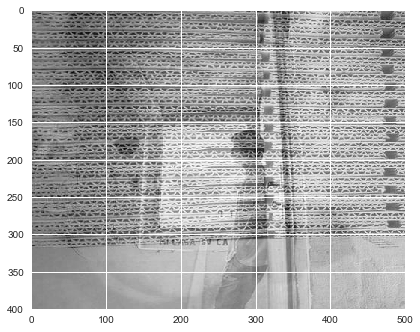

In [9]:
[yFeedback, WFeedback] = rgb_ICA(cichocki_Feedback, mixtures, 1e-6)

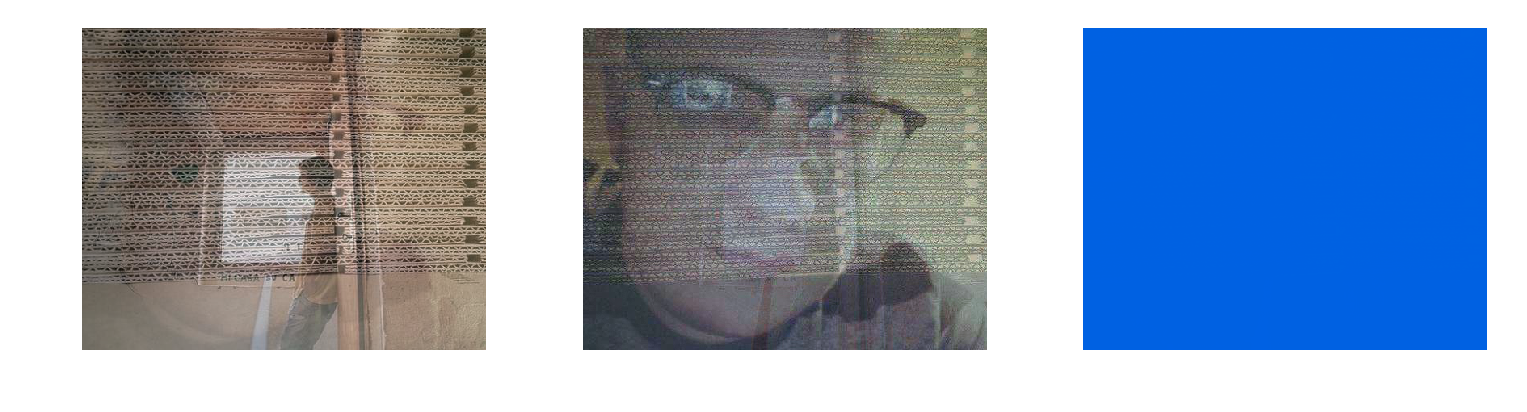

In [10]:
fig, axes = plt.subplots(1,3, dpi = 128+64)

womanFeedback = rebuildPicture(-yFeedback[0, :, 0], yFeedback[0, :, 1], yFeedback[0, :, 2], original_shape)
guyFeedback = rebuildPicture(yFeedback[1, :, 0], yFeedback[1, :, 1], yFeedback[1, :, 2], original_shape)
fernsterFeedback = rebuildPicture(yFeedback[2, :, 0], yFeedback[2, :, 1], -yFeedback[2, :, 2], original_shape)

axes[0].imshow(womanFeedback)
axes[1].imshow(guyFeedback)
axes[2].imshow(fernsterFeedback)
#axes[0].imshow(np.reshape(yFeedback[0,:,2], (400,500)), cmap = 'gray')
#axes[1].imshow(np.reshape(yFeedback[1,:,2], (400,500)), cmap = 'gray')
#axes[2].imshow(np.reshape(-yFeedback[2,:,2], (400,500)), cmap = 'gray')

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

fig.tight_layout()

In [11]:
print(WFeedback[0])
print(WFeedback[1])
print(WFeedback[2])

[[  1.00025286e+00   8.96914157e-05   1.98315758e-05]
 [  1.19300102e-04   1.00018233e+00  -3.15775716e-05]
 [ -1.39705325e-01   1.75249792e-01   7.32584326e-01]]
[[  1.00025286e+00   8.96914157e-05   1.98315758e-05]
 [  1.19300102e-04   1.00018233e+00  -3.15775716e-05]
 [ -1.39705325e-01   1.75249792e-01   7.32584326e-01]]
[[  1.00025286e+00   8.96914157e-05   1.98315758e-05]
 [  1.19300102e-04   1.00018233e+00  -3.15775716e-05]
 [ -1.39705325e-01   1.75249792e-01   7.32584326e-01]]


## Cichocki-Unbehauen Algorithm Feedforward Network

(3, 200000)
Execution time: 27.91361427307129 seconds
(3, 200000)
(3, 200000, 3)


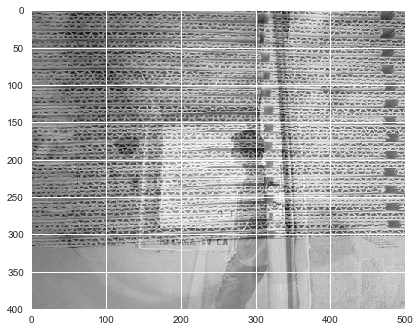

In [12]:
[yFeedForward, WFeedforward] = rgb_ICA(cichocki_Feedforward, mixtures, 1e-8)

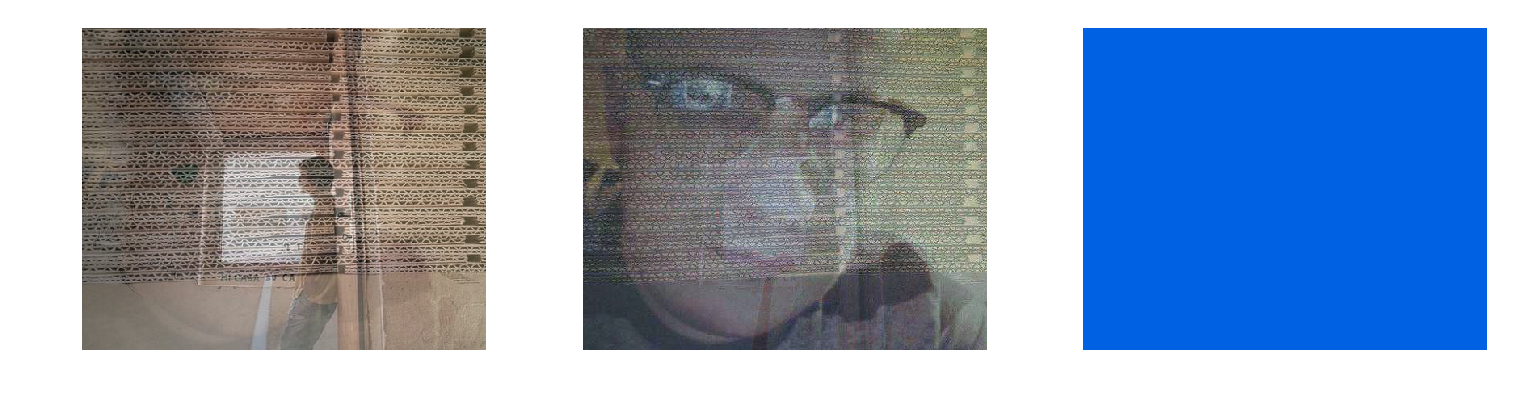

In [13]:
fig, axes = plt.subplots(1,3, dpi = 128+64)

womanFeedForward = rebuildPicture(-yFeedForward[0, :, 0], yFeedForward[0, :, 1], yFeedForward[0, :, 2], original_shape)
guyFeedForward = rebuildPicture(yFeedForward[1, :, 0], yFeedForward[1, :, 1], yFeedForward[1, :, 2], original_shape)
fernsterFeedForward = rebuildPicture(yFeedForward[2, :, 0], yFeedForward[2, :, 1], -yFeedForward[2, :, 2], original_shape)

axes[0].imshow(womanFeedForward)
axes[1].imshow(guyFeedForward)
axes[2].imshow(fernsterFeedForward)

#axes[0].imshow(np.reshape(yFeedForward[0,:,2], (400,500)), cmap = 'gray')
#axes[1].imshow(np.reshape(yFeedForward[1,:,2], (400,500)), cmap = 'gray')
#axes[2].imshow(np.reshape(-yFeedForward[2,:,2], (400,500)), cmap = 'gray')

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

fig.tight_layout()

# Fontes conhecidas

In [14]:
folderPathSource = 'base_imagens_ica\\2_run_key'
manSource = imread(folderPathSource + '\Bored face 1.jpg')
womanSource = imread(folderPathSource + '\Bored pose 1.jpg')
boardSource = imread(folderPathSource + '\Cardboard 1.jpg')

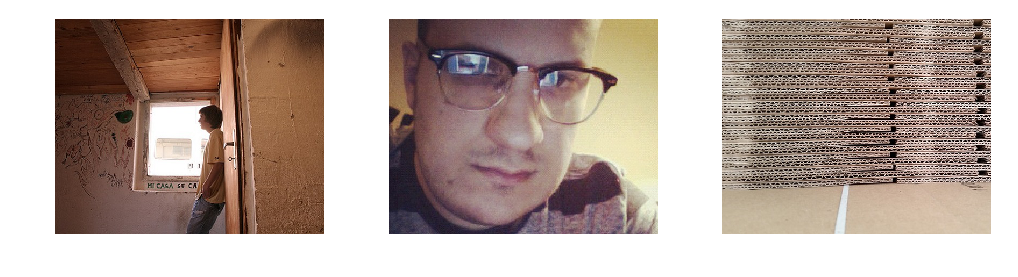

In [15]:
fig, axes = plt.subplots(1,3, dpi = 128)
axes[0].imshow(womanSource)
axes[1].imshow(manSource)
axes[2].imshow(boardSource)

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

fig.tight_layout()

In [16]:
sources = np.concatenate((womanSource[np.newaxis, :,:,:], 
                          manSource[np.newaxis, :, :, :],
                          boardSource[np.newaxis, :, :, :]))
sources.shape

(3, 400, 500, 3)

## NPCA-RLS

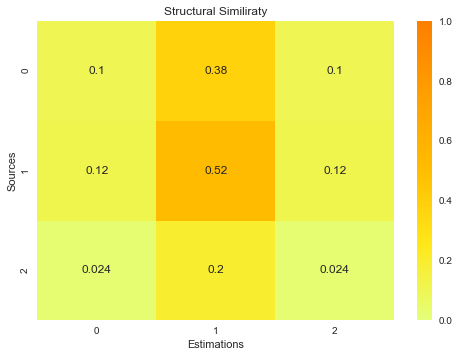

In [53]:
from evaluation import SSIMmatrix
rescaledwomanNPCA = (womanNPCA*255).astype('uint8')
rescaledguyNPCA = (guyNPCA*255).astype('uint8')
rescaledfernsterNPCA = (fernsterNPCA*255).astype('uint8')


estimationsNPCA = np.concatenate((rescaledwomanNPCA[np.newaxis, :, :, :], 
                                  rescaledguyNPCA[np.newaxis, :, :, :],
                                  rescaledfernsterNPCA[np.newaxis, :, :, :]))
SSIMmatrix(sources[:, :, :, 0], estimationsNPCA[:, :, :, 0])

## Cichocki-Unbehauen Algorithm Feedback Network

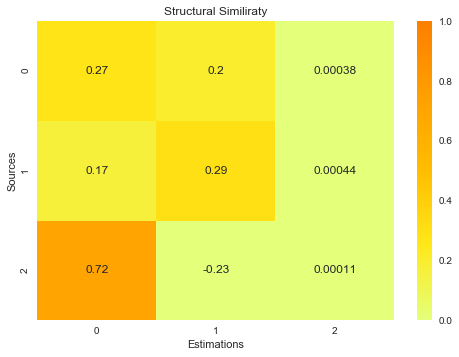

In [55]:
rescaledwomanFeedback = (womanFeedback*255).astype('uint8')
rescaledguyFeedback = (guyFeedback*255).astype('uint8')
rescaledfernsterFeedback = (fernsterFeedback*255).astype('uint8')


estimationsFeedback = np.concatenate((rescaledwomanFeedback[np.newaxis, :, :, :], 
                                      rescaledguyFeedback[np.newaxis, :, :, :],
                                      rescaledfernsterFeedback[np.newaxis, :, :, :]))
SSIMmatrix(sources[:, :, :, 0], estimationsFeedback[:, :, :, 0])

## Cichocki-Unbehauen Algorithm Feedforward Network

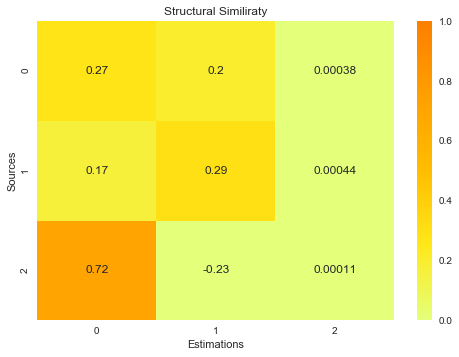

In [56]:
rescaledwomanFeedforward = (womanFeedForward*255).astype('uint8')
rescaledguyFeedforward = (guyFeedForward*255).astype('uint8')
rescaledfernsterFeedforward = (fernsterFeedForward*255).astype('uint8')


estimationsFeedforward = np.concatenate((rescaledwomanFeedforward[np.newaxis, :, :, :], 
                                         rescaledguyFeedforward[np.newaxis, :, :, :],
                                         rescaledfernsterFeedforward[np.newaxis, :, :, :]))
SSIMmatrix(sources[:, :, :, 0], estimationsFeedforward[:, :, :, 0])